<a href="https://colab.research.google.com/github/roxyrong/emotion_detection/blob/main/Traditional_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules for google cloud
from google.colab import auth
from google.cloud import storage
auth.authenticate_user()
client = storage.Client()

# Import other packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D, AveragePooling2D, Concatenate
from keras.constraints import MinMaxNorm, maxnorm
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# === Function: Convert npy to dataframe
def load_data(npy_data_path,csv_data_path):
    '''

    :param npy_data_path: NPY data Path
    :param csv_data_path:  CSV data Path
    :return: feature extraction dataframe
    '''
    audio_feature_file = np.load(file=npy_data_path,allow_pickle=True)
    data = pd.read_csv(csv_data_path)
    column_list = data.columns.to_list()
    augmented_data = pd.DataFrame(columns = column_list)
    for i in range(0,len(audio_feature_file)):
        row_list = []
        for item in range(0,len(column_list)):
            row_list.append(audio_feature_file[i][item])
        augmented_data.loc[len(augmented_data)+1] = row_list
    print(augmented_data.info())
    return augmented_data

In [ ]:
# === connect to SAVEE dataset
bucket = client.get_bucket('savee')
blob = bucket.blob('raw_audio_features_extraction_0324.npy')
blob.download_to_filename('features.npy')
blob = bucket.blob('raw_audio_features_extraction_0324.csv')
blob.download_to_filename('features.csv')

In [ ]:
df = load_data('features.npy', 'features.csv')
df.loc[df['path'].str.contains('sa'), 'emotion'] = 'sa'
data = df.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 1 to 1920
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data                   1920 non-null   object 
 1   path                   1920 non-null   object 
 2   dataset                1920 non-null   object 
 3   emotion                1920 non-null   object 
 4   speaker                1920 non-null   object 
 5   augmented              1920 non-null   bool   
 6   f0                     1920 non-null   object 
 7   pitch_mean             1920 non-null   float64
 8   pitch_median           1920 non-null   float64
 9   pitch_std              1920 non-null   float64
 10  pitch_range            1920 non-null   float64
 11  pitch_max              1920 non-null   float64
 12  energy_mean            1920 non-null   float64
 13  energy_median          1920 non-null   float64
 14  energy_std             1920 non-null   float64
 15  ener

In [ ]:
print(df['emotion'].value_counts())
le = LabelEncoder().fit(df['emotion'].unique())
df['label'] = le.transform(df['emotion'])

n     480
a     240
d     240
f     240
h     240
sa    240
su    240
Name: emotion, dtype: int64


In [ ]:
basic_feature_cols =  ['pitch_mean', 'pitch_median',  'pitch_std', 
                       'energy_mean', 'jitter', 'shimmer']
group_col = 'path'

features_1d = ['rms', 'zcr', 'ber', 'spec_flux', 'spec_bandwidth']
features_1d_new = []

features_2d = ['mfcc']

In [ ]:
def max_size(data):
    max_row_size = 0

    # Iterate through the Series to find the maximum row and column sizes
    for array in data:
        row_size = array.shape[0]
        max_row_size = max(max_row_size, row_size)
    return max_row_size

def resize_1d(x, max_row_size):
  return np.pad(x, pad_width=(0, max_row_size - x.shape[0]), mode='constant', constant_values=0)


for f in features_1d:
  max_row_size = max_size(data[f])
  print(max_row_size)
  df[f] = df[f].apply(lambda x: resize_1d(x, max_row_size))

290
290
290
290
290


In [ ]:
for f in features_1d:
  if f == 'teo':
    n = 4
  else:
    n = 2
  pca = PCA(n_components=n)
  temp_data = np.array([i.tolist() for i in df[f]])
  cols = [f + '_' + str(i) for i in range(n)]
  df[cols] = pd.DataFrame(pca.fit_transform(temp_data), columns=cols)
  features_1d_new += cols
  print(pca.explained_variance_ratio_)


[0.46722676 0.08107437]
[0.50653862 0.11766271]
[0.21733503 0.13702776]
[0.08558559 0.03039487]
[0.55142693 0.16317419]


In [ ]:
features_1d_new

['rms_0',
 'rms_1',
 'zcr_0',
 'zcr_1',
 'ber_0',
 'ber_1',
 'spec_flux_0',
 'spec_flux_1',
 'spec_bandwidth_0',
 'spec_bandwidth_1']

In [ ]:
features = basic_feature_cols + features_1d_new + [group_col]

In [ ]:
df = df.dropna()

In [ ]:
X = df[features].dropna()
y = df['label']

<Axes: >

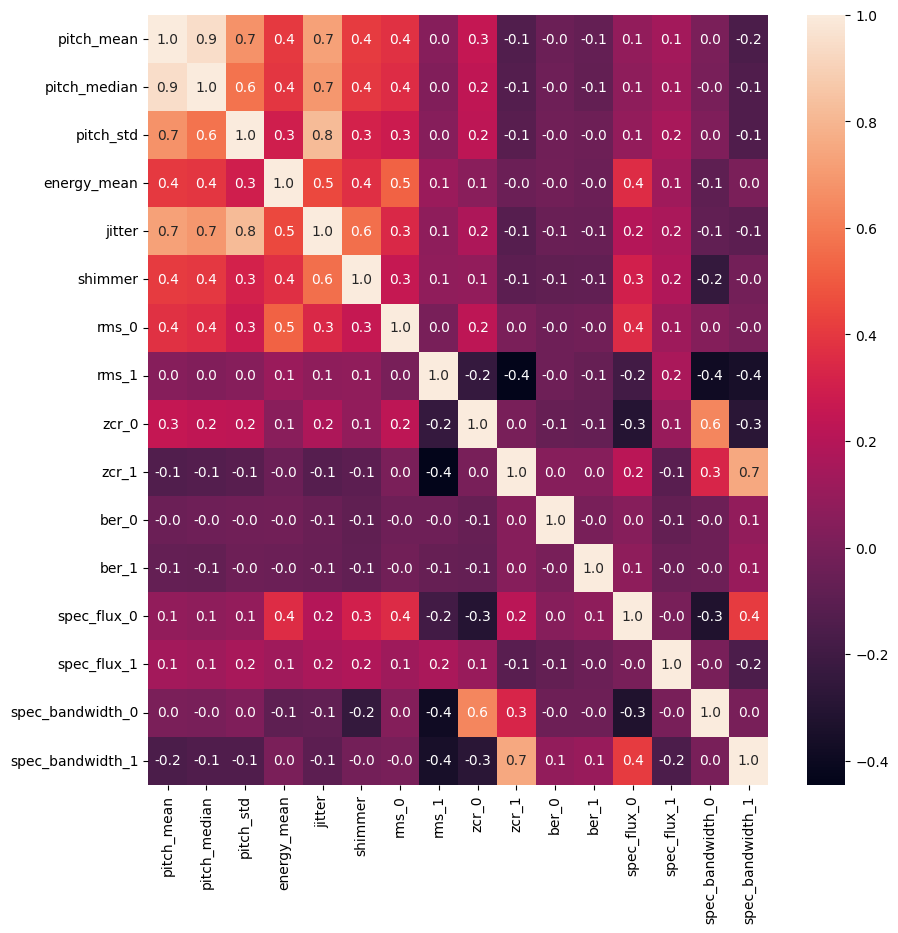

In [ ]:
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_matrix, annot=True, fmt=".1f", ax=ax)

In [ ]:
# Train Test Split

sgkf = StratifiedGroupKFold(n_splits=4)
for train_index, test_index in sgkf.split(X, y, X[group_col]):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train[group_col].value_counts().sort_index())
print(len(X_train[group_col].value_counts()))
print(X_test[group_col].value_counts().sort_index())
print(len(X_test[group_col].value_counts()))
X_train.drop(group_col, axis=1, inplace=True)
X_test.drop(group_col, axis=1, inplace=True)

AudioData/DC/a01.wav     4
AudioData/DC/a02.wav     4
AudioData/DC/a03.wav     4
AudioData/DC/a06.wav     4
AudioData/DC/a07.wav     4
                        ..
AudioData/KL/su09.wav    4
AudioData/KL/su10.wav    4
AudioData/KL/su12.wav    4
AudioData/KL/su13.wav    4
AudioData/KL/su14.wav    4
Name: path, Length: 360, dtype: int64
360
AudioData/DC/a04.wav     4
AudioData/DC/a05.wav     4
AudioData/DC/a12.wav     4
AudioData/DC/d01.wav     4
AudioData/DC/d05.wav     4
                        ..
AudioData/KL/sa14.wav    4
AudioData/KL/su03.wav    4
AudioData/KL/su07.wav    4
AudioData/KL/su11.wav    4
AudioData/KL/su15.wav    3
Name: path, Length: 120, dtype: int64
120


<ipython-input-14-a69edc94b589>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(group_col, axis=1, inplace=True)
<ipython-input-14-a69edc94b589>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(group_col, axis=1, inplace=True)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(1440, 16)
(479, 16)


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

4    360
0    180
1    180
2    180
3    180
5    180
6    180
Name: label, dtype: int64
4    120
0     60
1     60
2     60
3     60
5     60
6     59
Name: label, dtype: int64


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0, 
                         multi_class='multinomial', 
                         class_weight='balanced',
                         solver='lbfgs', 
                         max_iter=500).fit(X_train, y_train)

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train accuracy:  0.4826388888888889
test accuracy:  0.40501043841336115
              precision    recall  f1-score   support

           0       0.34      0.45      0.39        60
           1       0.13      0.10      0.11        60
           2       0.28      0.32      0.30        60
           3       0.42      0.18      0.26        60
           4       0.64      0.70      0.67       120
           5       0.35      0.38      0.37        60
           6       0.38      0.41      0.39        59

    accuracy                           0.41       479
   macro avg       0.36      0.36      0.35       479
weighted avg       0.40      0.41      0.39       479



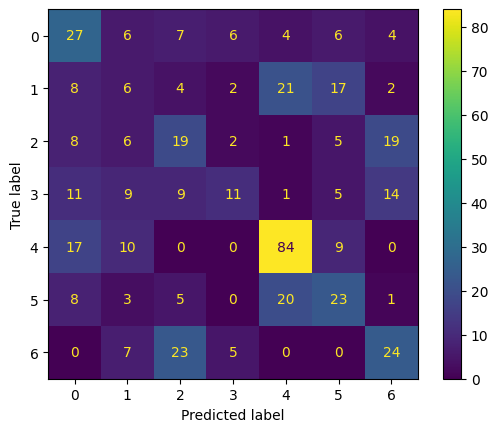

In [ ]:
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))
print(classification_report(y_test, y_test_pred)) 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

SVM

In [ ]:
from sklearn import svm
clf = svm.SVC(class_weight='balanced')
clf.fit(X_train, y_train)

SVC(class_weight='balanced')

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train accuracy:  0.5756944444444444
test accuracy:  0.4342379958246347
              precision    recall  f1-score   support

           0       0.39      0.37      0.38        60
           1       0.20      0.18      0.19        60
           2       0.30      0.20      0.24        60
           3       0.29      0.33      0.31        60
           4       0.69      0.75      0.72       120
           5       0.42      0.53      0.47        60
           6       0.40      0.36      0.38        59

    accuracy                           0.43       479
   macro avg       0.38      0.39      0.38       479
weighted avg       0.42      0.43      0.43       479



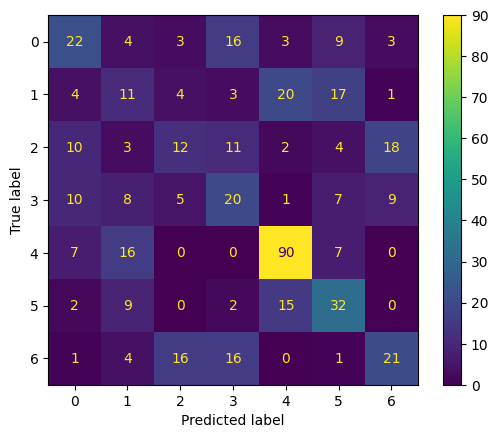

In [ ]:
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))
print(classification_report(y_test, y_test_pred)) 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, min_samples_split=10, 
                             min_samples_leaf = 20,
                             class_weight='balanced', random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=20, min_samples_split=10,
                       random_state=0)

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train accuracy:  0.5375
test accuracy:  0.4613778705636743
              precision    recall  f1-score   support

           0       0.41      0.38      0.40        60
           1       0.11      0.07      0.08        60
           2       0.57      0.13      0.22        60
           3       0.30      0.38      0.34        60
           4       0.62      0.88      0.73       120
           5       0.44      0.38      0.41        60
           6       0.46      0.58      0.51        59

    accuracy                           0.46       479
   macro avg       0.42      0.40      0.38       479
weighted avg       0.44      0.46      0.43       479



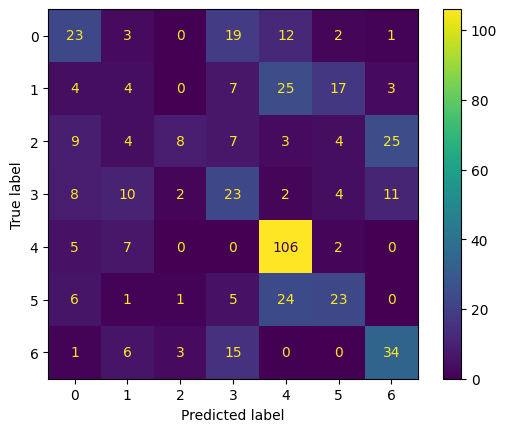

In [ ]:
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))
print(classification_report(y_test, y_test_pred)) 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
y_train_pred = neigh.predict(X_train)
y_test_pred = neigh.predict(X_test)

ari: 0.22126874254288018
nmi: 0.21603564914322662
train accuracy:  0.6138888888888889
test accuracy:  0.3966597077244259
              precision    recall  f1-score   support

           0       0.27      0.27      0.27        60
           1       0.16      0.13      0.15        60
           2       0.30      0.22      0.25        60
           3       0.29      0.32      0.30        60
           4       0.59      0.80      0.68       120
           5       0.38      0.30      0.34        60
           6       0.41      0.34      0.37        59

    accuracy                           0.40       479
   macro avg       0.34      0.34      0.34       479
weighted avg       0.37      0.40      0.38       479



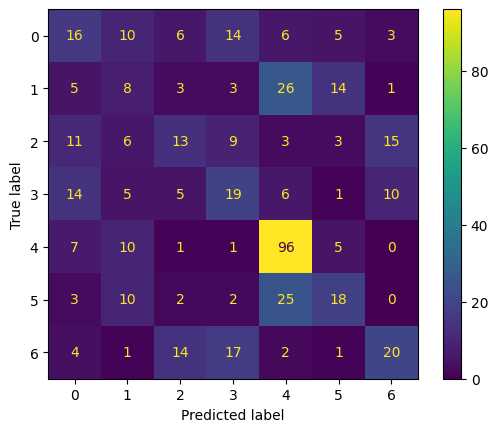

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
print('ari:', adjusted_rand_score(y_test, y_test_pred))
print('nmi:', normalized_mutual_info_score(y_test, y_test_pred))
print('train accuracy: ', neigh.score(X_train, y_train))
print('test accuracy: ', neigh.score(X_test, y_test))
print(classification_report(y_test, y_test_pred)) 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

Preparing dataset for CNN

In [ ]:
# Resizing the params
def max_size(data):
    max_row_size = 0
    max_column_size = 0

    # Iterate through the Series to find the maximum row and column sizes
    for array in data:
        row_size, column_size = array.shape
        max_row_size = max(max_row_size, row_size)
        max_column_size = max(max_column_size, column_size)
    return max_row_size, max_column_size

def resize(x):
  return np.pad(x, pad_width=((0, max_row_size - x.shape[0]), 
                            (0, max_column_size - x.shape[1])),
                            mode='constant')
  

max_row_size, max_column_size = max_size(df['mfcc'])
print(max_row_size, max_column_size)
df['mfcc'] = df['mfcc'].apply(resize)
max_row_size, max_column_size = max_size(df['mel_spetrogram'])
print(max_row_size, max_column_size)
df['mel_spetrogram'] = df['mel_spetrogram'].apply(resize)

40 290
128 290


In [ ]:
features.append('mfcc')
features.append('mel_spetrogram')

In [ ]:
X = df[features]
y = df['label']

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in sgkf.split(X, y, X.path):
    X_temp, X_test = X.iloc[train_index], X.iloc[test_index]
    y_temp, y_test = y.iloc[train_index], y.iloc[test_index]

sgkf_2 = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, val_index in sgkf_2.split(X_temp, y_temp, X_temp.path):
    X_train, X_val = X_temp.iloc[train_index], X_temp.iloc[val_index]
    y_train, y_val = y_temp.iloc[train_index], y_temp.iloc[val_index]

print(X_train['path'].value_counts().sort_index())
print(len(X_train['path'].value_counts()))
print(X_val['path'].value_counts().sort_index())
print(len(X_val['path'].value_counts()))
print(X_test['path'].value_counts().sort_index())
print(len(X_test['path'].value_counts()))
X_train = X_train.drop(columns='path')

AudioData/DC/a01.wav     4
AudioData/DC/a02.wav     4
AudioData/DC/a03.wav     4
AudioData/DC/a05.wav     4
AudioData/DC/a06.wav     4
                        ..
AudioData/KL/su07.wav    4
AudioData/KL/su09.wav    4
AudioData/KL/su13.wav    4
AudioData/KL/su14.wav    4
AudioData/KL/su15.wav    3
Name: path, Length: 271, dtype: int64
271
AudioData/DC/a09.wav     4
AudioData/DC/a12.wav     4
AudioData/DC/d02.wav     4
AudioData/DC/d09.wav     4
AudioData/DC/d11.wav     4
                        ..
AudioData/KL/sa02.wav    4
AudioData/KL/sa12.wav    4
AudioData/KL/su05.wav    4
AudioData/KL/su08.wav    4
AudioData/KL/su11.wav    4
Name: path, Length: 89, dtype: int64
89
AudioData/DC/a04.wav     4
AudioData/DC/a11.wav     4
AudioData/DC/a14.wav     4
AudioData/DC/a15.wav     4
AudioData/DC/d05.wav     4
                        ..
AudioData/KL/sa09.wav    4
AudioData/KL/sa15.wav    4
AudioData/KL/su06.wav    4
AudioData/KL/su10.wav    4
AudioData/KL/su12.wav    4
Name: path, Length: 120, dt

CNN model

In [ ]:
def build_model(n_classes=7,
                optimizer='Adam',
                learning_rate=0.001):
  
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  image_input = Input((40, 290, 1), name='image_input')
  x = Conv2D(32, (5,15),activation='relu')(image_input)
  x = BatchNormalization()(x)
  x = AveragePooling2D(3,9)(x)
  x = Dropout(0.2)(x)
  x = Conv2D(16, (3,9),activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2,2)(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(units=64, activation='relu', kernel_constraint=maxnorm(3))(x)
  x = Dropout(0.5)(x)
  x = Dense(units=16, activation='relu', kernel_constraint=maxnorm(3))(x)
  x = Dropout(0.2)(x)
  output = Dense(units=n_classes, activation='softmax')(x)

  model = Model(inputs=image_input, outputs=output)
  # Optimizers
  if optimizer == "SGD":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
  elif optimizer == "Adam":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])

  return model

In [ ]:
def train_and_evaluate(X_train=X_train,
                      y_train=y_train,
                      X_val=X_val,
                      y_val=y_val,
                      X_test=X_test,
                      y_test=y_test,
                      activation='relu',
                      optimizer='SGD',
                      learning_rate=0.01,
                      num_epochs=5):
  
  X_train_mfcc = np.array([i for i in X_train['mfcc']])
  X_val_mfcc = np.array([i for i in X_val['mfcc']])
  X_test_mfcc = np.array([i for i in X_test['mfcc']])

  y_train = np.array([i for i in y_train])
  y_val = np.array([i for i in y_val])
  y_test = np.array([i for i in y_test])

  # scale mfcc

  # Build the model.
  model = build_model(n_classes=7,
                      optimizer=optimizer,
                      learning_rate=learning_rate)


  # Train the model.
  print('Training...')

  from sklearn.utils import class_weight

  class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                    classes=np.unique(y_train),
                                                    y = y_train)
  class_weight_dict = dict(zip([x for x in np.unique(y_train)], class_weights))

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)

  history = model.fit(
    x=X_train_mfcc,
    y=y_train,
    class_weight=class_weight_dict,
    epochs=num_epochs,
    batch_size=64,
    validation_data=(X_val_mfcc, y_val),
    callbacks=[early_stopping],
    verbose=1)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test_mfcc, y=y_test, verbose=0,
                                 return_dict=True)['accuracy']

  y_test_pred = model.predict(X_test_mfcc)
  y_test_pred = np.argmax(y_test_pred, axis=1)


  # Classification Report
  print(classification_report(y_test, y_test_pred))
  # Confusiont Matrix
  target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)

  return test_accuracy

Training...
Epoch 1/100
17/17 [==============================] - 4s 44ms/step - loss: 2.5122 - accuracy: 0.1385 - val_loss: 2.2096 - val_accuracy: 0.2247
Epoch 2/100
17/17 [==============================] - 0s 24ms/step - loss: 1.9720 - accuracy: 0.1662 - val_loss: 2.0665 - val_accuracy: 0.2022
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 1.9441 - accuracy: 0.1921 - val_loss: 1.9327 - val_accuracy: 0.2135
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 1.9362 - accuracy: 0.1939 - val_loss: 1.9665 - val_accuracy: 0.2500
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 1.9243 - accuracy: 0.1782 - val_loss: 1.9283 - val_accuracy: 0.2247
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 1.9069 - accuracy: 0.2068 - val_loss: 1.9423 - val_accuracy: 0.1601
Epoch 7/100
17/17 [==============================] - 0s 24ms/step - loss: 1.9156 - accuracy: 0.1939 - val_loss: 1.9261 - val_accuracy: 0

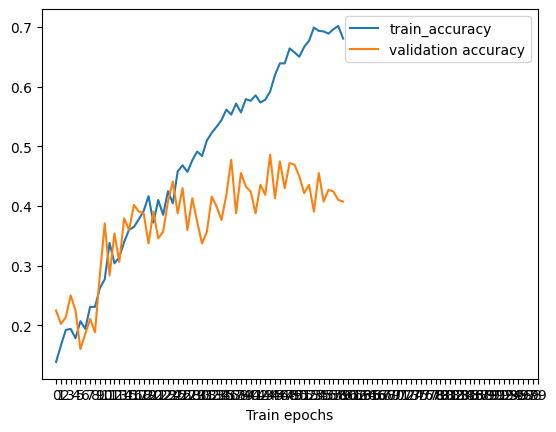

15/15 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.57      0.56      0.56        68
           1       0.18      0.31      0.23        48
           2       0.37      0.44      0.40        64
           3       0.32      0.12      0.18        56
           4       0.86      0.69      0.76       132
           5       0.37      0.44      0.40        52
           6       0.44      0.45      0.44        60

    accuracy                           0.48       480
   macro avg       0.44      0.43      0.43       480
weighted avg       0.51      0.48      0.49       480



0.47708332538604736

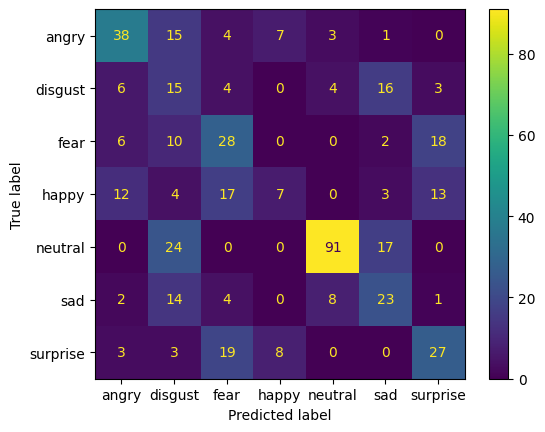

In [ ]:
train_and_evaluate(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    activation='relu',
    optimizer='Adam',
    learning_rate=0.0025,
    num_epochs=100)

In [ ]:
def build_model(n_classes=7,
                num_features=20,
                optimizer='Adam',
                learning_rate=0.001):
  
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  x1_input = Input((40, 290, 1), name='x1_input')
  x1 = Conv2D(64, (5,15),activation='relu')(x1_input)
  x1 = BatchNormalization()(x1)
  x1 = AveragePooling2D(3,9)(x1)
  x1 = Dropout(0.2)(x1)
  x1 = Conv2D(16, (3,9),activation='relu')(x1)
  x1 = BatchNormalization()(x1)
  x1 = MaxPool2D(2,2)(x1)
  x1 = Dropout(0.2)(x1)
  x1 = Flatten()(x1)

  x2_input = Input((128, 290, 1), name='x2_input')
  x2 = Conv2D(64, (5,15),activation='relu')(x2_input)
  x2 = BatchNormalization()(x2)
  x2 = AveragePooling2D(3,9)(x2)
  x2 = Dropout(0.2)(x2)
  x2 = Conv2D(16, (3,9), activation='relu')(x2)
  x2 = BatchNormalization()(x2)
  x2 = MaxPool2D(2,2)(x2)
  x2 = Dropout(0.2)(x2)
  x2 = Flatten()(x2)

  x = Concatenate()([x1, x2])
  x = BatchNormalization()(x)
  x = Dense(units=64, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)
  x = Dense(units=16, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  output = Dense(units=n_classes, activation='softmax')(x)

  model = Model(inputs=[x1_input, x2_input], outputs=output)
  # Optimizers
  if optimizer == "SGD":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
  elif optimizer == "Adam":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])

  return model
    


In [ ]:
def train_and_evaluate(X_train=X_train,
                      y_train=y_train,
                      X_val=X_val,
                      y_val=y_val,
                      X_test=X_test,
                      y_test=y_test,
                      activation='relu',
                      optimizer='SGD',
                      learning_rate=0.01,
                      num_epochs=5):
  
  X_train_input_1 = np.array([i for i in X_train['mfcc']])
  X_val_input_1 = np.array([i for i in X_val['mfcc']])
  X_test_input_1 = np.array([i for i in X_test['mfcc']])
  
  X_train_input_2 = np.array([i for i in X_train['mel_spetrogram']])
  X_val_input_2 = np.array([i for i in X_val['mel_spetrogram']])
  X_test_input_2 = np.array([i for i in X_test['mel_spetrogram']])

  y_train = np.array([i for i in y_train])
  y_val = np.array([i for i in y_val])
  y_test = np.array([i for i in y_test])

  # scale mfcc

  # Build the model.
  model = build_model(n_classes=7,
                      optimizer=optimizer,
                      learning_rate=learning_rate)


  # Train the model.
  print('Training...')

  from sklearn.utils import class_weight

  class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                    classes=np.unique(y_train),
                                                    y = y_train)
  class_weight_dict = dict(zip([x for x in np.unique(y_train)], class_weights))

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)

  history = model.fit(
    x=[X_train_input_1, X_train_input_2],
    y=y_train,
    class_weight=class_weight_dict,
    epochs=num_epochs,
    batch_size=64,
    validation_data=([X_val_input_1, X_val_input_2], y_val),
    callbacks=[early_stopping],
    verbose=1)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=[X_test_input_1, X_test_input_2], y=y_test, verbose=0,
                                 return_dict=True)['accuracy']

  y_test_pred = model.predict([X_test_input_1, X_test_input_2])
  y_test_pred = np.argmax(y_test_pred, axis=1)


  # Classification Report
  print(classification_report(y_test, y_test_pred))
  # Confusiont Matrix
  target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)

  return test_accuracy

Training...
Epoch 1/100
17/17 [==============================] - 10s 229ms/step - loss: 2.1618 - accuracy: 0.1717 - val_loss: 24.7027 - val_accuracy: 0.2444
Epoch 2/100
17/17 [==============================] - 3s 161ms/step - loss: 2.0096 - accuracy: 0.1865 - val_loss: 7.0035 - val_accuracy: 0.2247
Epoch 3/100
17/17 [==============================] - 3s 161ms/step - loss: 1.9375 - accuracy: 0.2207 - val_loss: 4.1006 - val_accuracy: 0.2051
Epoch 4/100
17/17 [==============================] - 3s 161ms/step - loss: 1.8391 - accuracy: 0.2419 - val_loss: 2.7454 - val_accuracy: 0.2135
Epoch 5/100
17/17 [==============================] - 3s 161ms/step - loss: 1.7829 - accuracy: 0.2669 - val_loss: 2.0736 - val_accuracy: 0.2472
Epoch 6/100
17/17 [==============================] - 3s 162ms/step - loss: 1.7462 - accuracy: 0.2687 - val_loss: 1.8137 - val_accuracy: 0.3539
Epoch 7/100
17/17 [==============================] - 3s 161ms/step - loss: 1.6538 - accuracy: 0.3306 - val_loss: 1.6050 - val_ac

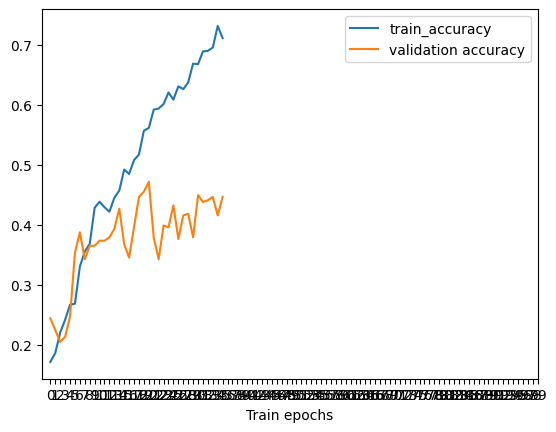

15/15 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.44      0.65      0.52        68
           1       0.16      0.27      0.20        48
           2       0.40      0.27      0.32        64
           3       0.26      0.29      0.27        56
           4       0.83      0.51      0.63       132
           5       0.38      0.46      0.41        52
           6       0.42      0.37      0.39        60

    accuracy                           0.42       480
   macro avg       0.41      0.40      0.39       480
weighted avg       0.48      0.42      0.44       480



0.4229166805744171

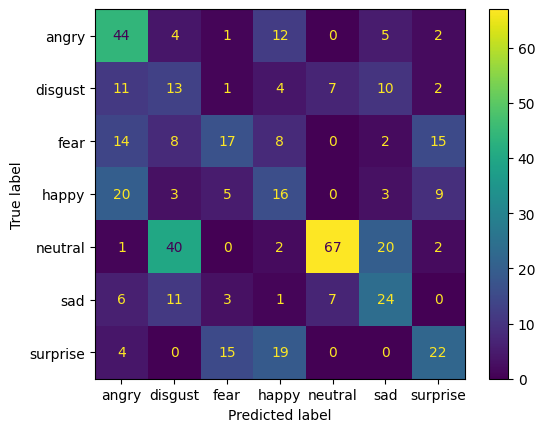

In [ ]:
train_and_evaluate(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    activation='relu',
    optimizer='Adam',
    learning_rate=0.005,
    num_epochs=100)

CNN + others

In [ ]:
def build_model(n_classes=7,
                num_features=20,
                optimizer='Adam',
                learning_rate=0.001):
  
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  image_input = Input((40, 290, 1), name='image_input')
  x1 = Conv2D(64, (5,5),activation='relu')(image_input)
  x1 = BatchNormalization()(x1)
  x1 = AveragePooling2D(3,3)(x1)
  x1 = Dropout(0.2)(x1)
  x1 = Conv2D(16, (3,9),activation='relu')(x1)
  x1 = BatchNormalization()(x1)
  x1 = MaxPool2D(2,2)(x1)
  x1 = Dropout(0.2)(x1)
  x1 = Flatten()(x1)

  other_features_input = Input(shape=(num_features,), name='other_features_input')

  x = Concatenate()([x1, other_features_input])
  x = BatchNormalization()(x)
  x = Dense(units=32, activation='relu', activity_regularizer=regularizers.L2(0.001))(x)
  # x = Dense(units=16, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),)(x)
  x = Dropout(0.5)(x)
  output = Dense(units=n_classes, activation='softmax')(x)

  model = Model(inputs=[image_input, other_features_input], outputs=output)
  # Optimizers
  if optimizer == "SGD":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
  elif optimizer == "Adam":
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])

  return model
    


In [ ]:
def train_and_evaluate(X_train=X_train,
                      y_train=y_train,
                      X_val=X_val,
                      y_val=y_val,
                      X_test=X_test,
                      y_test=y_test,
                      activation='relu',
                      optimizer='SGD',
                      learning_rate=0.01,
                      num_epochs=5):
  
  X_train_mfcc = np.array([i for i in X_train['mfcc']])
  X_val_mfcc = np.array([i for i in X_val['mfcc']])
  X_test_mfcc = np.array([i for i in X_test['mfcc']])

  other_features = X_train.columns[:-1]
  X_train_others = np.array([row.values for i, row in X_train[other_features].iterrows()])
  X_val_others = np.array([row.values for i, row in X_val[other_features].iterrows()])
  X_test_others = np.array([row.values for i, row in X_test[other_features].iterrows()])


  y_train = np.array([i for i in y_train])
  y_val = np.array([i for i in y_val])
  y_test = np.array([i for i in y_test])

  # Build the model.
  model = build_model(n_classes=7,
                      num_features=len(other_features),
                      optimizer=optimizer,
                      learning_rate=learning_rate)


  # Train the model.
  print('Training...')

  from sklearn.utils import class_weight

  class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                    classes=np.unique(y_train),
                                                    y = y_train)
  class_weight_dict = dict(zip([x for x in np.unique(y_train)], class_weights))

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)

  history = model.fit(
    x=[X_train_mfcc, X_train_others],
    y=y_train,
    class_weight=class_weight_dict,
    epochs=num_epochs,
    batch_size=64,
    validation_data=([X_val_mfcc, X_val_others], y_val),
    callbacks=[early_stopping],
    verbose=1)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=[X_test_mfcc, X_test_others], y=y_test, verbose=0,
                                 return_dict=True)['accuracy']

  y_test_pred = model.predict([X_test_mfcc, X_test_others])
  y_test_pred = np.argmax(y_test_pred, axis=1)


  # Classification Report
  print(classification_report(y_test, y_test_pred))
  # Confusiont Matrix
  target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)

  return test_accuracy

Training...
Epoch 1/100
17/17 [==============================] - 5s 81ms/step - loss: 2.6814 - accuracy: 0.2114 - val_loss: 2.3886 - val_accuracy: 0.2781
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 2.0586 - accuracy: 0.3389 - val_loss: 2.1342 - val_accuracy: 0.2725
Epoch 3/100
17/17 [==============================] - 1s 47ms/step - loss: 1.8522 - accuracy: 0.3712 - val_loss: 1.8238 - val_accuracy: 0.3118
Epoch 4/100
17/17 [==============================] - 1s 47ms/step - loss: 1.7460 - accuracy: 0.3980 - val_loss: 1.7137 - val_accuracy: 0.3258
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 1.6030 - accuracy: 0.4303 - val_loss: 1.5856 - val_accuracy: 0.3989
Epoch 6/100
17/17 [==============================] - 1s 47ms/step - loss: 1.5584 - accuracy: 0.4432 - val_loss: 1.6253 - val_accuracy: 0.3764
Epoch 7/100
17/17 [==============================] - 1s 47ms/step - loss: 1.4309 - accuracy: 0.4792 - val_loss: 1.5298 - val_accuracy: 0

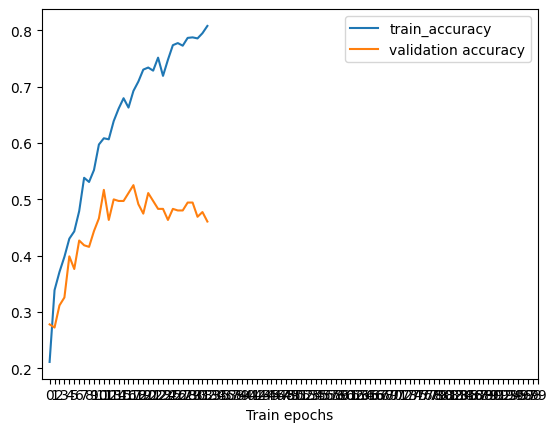

15/15 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        68
           1       0.39      0.15      0.21        48
           2       0.33      0.36      0.34        64
           3       0.42      0.23      0.30        56
           4       0.74      0.92      0.82       132
           5       0.43      0.65      0.52        52
           6       0.47      0.38      0.42        60

    accuracy                           0.55       480
   macro avg       0.49      0.48      0.46       480
weighted avg       0.53      0.55      0.53       480



0.5520833134651184

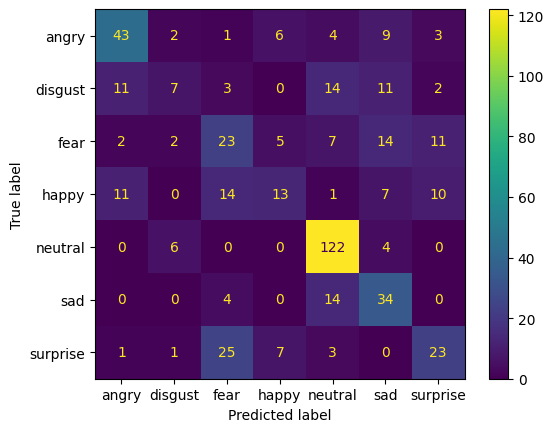

In [ ]:
train_and_evaluate(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    activation='relu',
    optimizer='Adam',
    learning_rate=0.0005,
    num_epochs=100)